# Shopify Summer 2022 Data Science Intern Challenge
## Manan Biyani

## Q1a
Importing libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
shopify = pd.read_csv("../data/shopify_data.csv",sep='\t')
data = shopify.copy()
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,13-03-2017 12:36
1,2,92,925,90,1,cash,03-03-2017 17:38
2,3,44,861,144,1,cash,14-03-2017 04:23
3,4,18,935,156,1,credit_card,26-03-2017 12:43
4,5,18,883,156,1,credit_card,01-03-2017 04:35


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


Looks like we do not have any null columns. created_at column is supposed to be datetime, so we will convert it from dtype object.

In [4]:
# Converted created_at column to datetime format
data.created_at = pd.to_datetime(data.created_at,format = '%d-%m-%Y %H:%S')
data.created_at.head()

0   2017-03-13 12:00:36
1   2017-03-03 17:00:38
2   2017-03-14 04:00:23
3   2017-03-26 12:00:43
4   2017-03-01 04:00:35
Name: created_at, dtype: datetime64[ns]

Let's have a look at the data set description

In [5]:
data[['order_amount','total_items']].describe().round(2)

,order_amount,total_items
count,5000.00,5000.00
mean,3145.13,8.79
std,41282.54,116.32
min,90.00,1.00
25%,163.00,1.00
50%,284.00,2.00
75%,390.00,3.00
max,704000.00,2000.00


As it says in the question description, the AOV is $3145.13, which is unnaturally high for an affordable item like sneakers.
However, the argument made in the question fails to consider the total number of items in an order i.e., the average value of sneakers is not defined by the order amount. For that, we need to divide the order amount by the total number of items in that order. 

We will create a new feature 'sneaker_amount' which describes the the average cost of a sneaker in an order.

In [6]:
data['sneaker_amount'] = data.order_amount/data.total_items
data[['order_amount','total_items','sneaker_amount']].head()

,order_amount,total_items,sneaker_amount
0,224,2,112.0
1,90,1,90.0
2,144,1,144.0
3,156,1,156.0
4,156,1,156.0


Now we can see the per sneaker cost in the column 'sneaker_amount'. Lets have a look at the average sneaker cost

In [7]:
print('Average cost of a sneaker  is $%f'%data.sneaker_amount.mean())

Average cost of a sneaker  is $387.742800


Is this cost still high? Naively, we can say yes. Let's have a look at the median and standard deviation to determine if this price is high and then we can look at the possible reasons.

In [8]:
data.sneaker_amount.describe()

count     5000.000000
mean       387.742800
std       2441.963725
min         90.000000
25%        133.000000
50%        153.000000
75%        169.000000
max      25725.000000
Name: sneaker_amount, dtype: float64

The median is is somewhat the price of a normal sneaker, and could be used as a better metric. For now, lets look at the standard deviation. 

The standard deviation clearly is very high (2441.963725), indicating presence of outliers, which we can term as ***certain shops selling sneakers for very high prices compared to normal prices***. The max amount of 25725 is also an indicator of the same.
This is ***overpricing***. So, let's check out the outliers.

In [9]:
# Shops Overpricing
grdp_data = data[['shop_id','order_amount','total_items','sneaker_amount']].groupby('shop_id').mean().sort_values(by=['sneaker_amount','total_items','order_amount'],ascending=False)
grdp_data

,order_amount,total_items,sneaker_amount
shop_id,,,
78,49213.043478,1.913043,25725.0
42,235101.490196,667.901961,352.0
12,352.698113,1.754717,201.0
89,379.147541,1.934426,196.0
99,339.444444,1.740741,195.0
...,...,...,...
53,214.117647,1.911765,112.0
100,213.675000,1.925000,111.0
32,189.976190,1.880952,101.0


By looking at this, we can make following observations -

1. The average sneaker cost by shop 78 is very very high, indicating that this shop is skewing the the average sneaker cost and the AOV. 
2. The average amount of ordered items at shop 42 is very high, indicating that this shop sold high amount of sneakers at a relatively higher cost of $352. We can look at the shop's details.

Let's visualize this on the orginal data (not grouped) - 

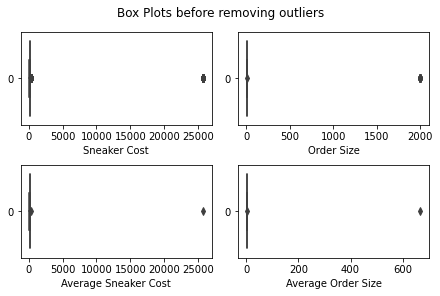

In [10]:
fig, axs = plt.subplots(2,2,constrained_layout = True)
sns.boxplot(data=data.sneaker_amount,ax=axs[0,0],orient='h')
axs[0,0].set(ylabel='', xlabel='Sneaker Cost')
sns.boxplot(data=data.total_items,ax=axs[0,1],orient='h')
axs[0,1].set(ylabel='', xlabel='Order Size')
sns.boxplot(data=np.array(grdp_data.sneaker_amount),ax=axs[1,0],orient='h')
axs[1,0].set(ylabel='', xlabel='Average Sneaker Cost')
sns.boxplot(data=np.array(grdp_data.total_items),ax=axs[1,1],orient='h')
axs[1,1].set(ylabel='', xlabel='Average Order Size')
plt.suptitle("Box Plots before removing outliers")
plt.show()

Above visualization clearly tells us about very high pricing and very high order sizes instance's presence.

For Sneaker Cost, we can observe that shop 78 is causing the outliers. Let's verify this with the the quartiles for this feature. We already saw the 25% and 75% percentiles, and the sneaker cost. Considering that affordable sneakers are still a viable sale, we will look at the prices significantly higher than the Q3. 

For Total Items, we observed that shop 42 is causing the outliers. Let's have a look at Q3 to verify the same.

We can calculate the Q1 and Q3 the following way as well -

In [11]:
print('For Sneaker Cost\nQ1: %f, Q3: %f'%(np.quantile(data.sneaker_amount,0.25),np.quantile(data.sneaker_amount,0.75)))
print('For Total Items / Order Size\nQ1: %f, Q3: %f'%(np.quantile(data.total_items,0.25),np.quantile(data.total_items,0.75)))

For Sneaker Cost
Q1: 133.000000, Q3: 169.000000
For Total Items / Order Size
Q1: 1.000000, Q3: 3.000000


Let's have a look at shop 42's details -

In [12]:
data[data.shop_id==42][['order_amount','total_items','sneaker_amount']].describe()

,order_amount,total_items,sneaker_amount
count,51.000000,51.000000,51.0
mean,235101.490196,667.901961,352.0
std,334860.641587,951.308641,0.0
min,352.000000,1.000000,352.0
25%,352.000000,1.000000,352.0
50%,704.000000,2.000000,352.0
75%,704000.000000,2000.000000,352.0
max,704000.000000,2000.000000,352.0


We can see the AOV of shop 42 is very very high, along with the order size(total_items)

Clearly, only the average sneaker cost by shop 78 is significantly very high compared to the Q3.

Similarly, the average order size by shop 42 is significantly is very high compared to Q3.

So, we remove the data of these shops. We are not removing other shops with cost/ items Q3 because they are not as significantly high and still are viable costs for a sneaker.

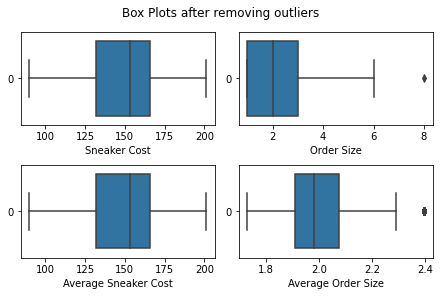

In [13]:
data = data[(data.shop_id!=78) & (data.shop_id!=42)]
grdp_data = grdp_data.filter(items = data.shop_id, axis=0)
fig, axs = plt.subplots(2,2,constrained_layout = True)
sns.boxplot(data=data.sneaker_amount,ax=axs[0,0],orient='h')
axs[0,0].set(ylabel='', xlabel='Sneaker Cost')
sns.boxplot(data=data.total_items,ax=axs[0,1],orient='h')
axs[0,1].set(ylabel='', xlabel='Order Size')
sns.boxplot(data=np.array(grdp_data.sneaker_amount),ax=axs[1,0],orient='h')
axs[1,0].set(ylabel='', xlabel='Average Sneaker Cost')
sns.boxplot(data=np.array(grdp_data.total_items),ax=axs[1,1],orient='h')
axs[1,1].set(ylabel='', xlabel='Average Order Size')
plt.suptitle('Box Plots after removing outliers')
plt.show()

In [14]:
data[['order_amount','total_items','sneaker_amount']].describe().round(decimals=2)

,order_amount,total_items,sneaker_amount
count,4903.00,4903.00,4903.00
mean,300.16,2.00,150.40
std,155.94,0.98,23.85
min,90.00,1.00,90.00
25%,163.00,1.00,132.00
50%,284.00,2.00,153.00
75%,386.50,3.00,166.00
max,1086.00,8.00,201.00


As we can see, now the average sneaker cost is $150.40, which is somewhere around the cost of a normal sneaker. Even the average order size (total_items) is 2.

So, to summarize the answers - 
In the naive analysis described in the question, AOV did not consider the order size to judge the average price of a sneaker i.e., did not consider that an order can have multiple sneakers. 

A better way, as aforementioned, dividing the order amount by the order size gives us a more accurate idea of the sneaker cost. Also, by removing the outliers, we get a clearer picture for the analysis of this dataset. 

Now we can report an AOV of 300 and also an Average Sneaker Value (ASV) of 150.40.

## Q1b
Now we need to think of a metric to describe the data.

In [15]:
shopify.order_amount.describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

Going back to the original dataset, instead of AOV, we can look at the median (50%) of the data. It gives a more representative value of the data. In this case, we will not have to do the process of removing outliers as well.

Hence, I would report Median as the metric for this dataset.

## Q1c
The value of the median is $284.00.

As a sanity check, the value is close to the AOV($300.16) when outliers were removed.